In [1]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')


In [11]:

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf



In [6]:
df = pd.read_csv('../../projects/data/bolcom-clicks-35m_test.txt', sep='\t')
df


,SessionId,Time,ItemId
0,0008019740_18,1585897352,9200000083733268
1,0008019740_18,1585897382,9200000049819763
2,0008019740_18,1585897392,9200000066323079
3,0008019740_18,1585897506,9200000081546242
4,0008019740_18,1585897633,9200000125623273
...,...,...,...
1211470,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921127,9200000065118578
1211471,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921160,9200000065118570
1211472,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921286,9200000064417495
1211473,zzzjsuzmx87wcp4720be75zq67m2hkx9_14,1585944407,9200000026328200


In [7]:
def create_index_df_from_column(argument_df, columnname):
    # create an index for the training item_ids, because we need this when training the model
    # this should be part of the train and serve code of an algorithm
    # usage:
    #     create_index_df_from_column(df, 'ItemId')
    # returns a two column dataframe:
    #   ItemId  idx
    #   9200000105095118    0
    #   9200000041902190    1
    #   9200000095595490    2
    token_id = {t: i for i, t in enumerate(argument_df[columnname].unique())}
    df_index = pd.DataFrame.from_dict(token_id, orient="index").reset_index()
    df_index.rename(columns={"index": columnname, 0: "idx"}, inplace=True)
    return df_index

In [8]:
item_pop_df = df.groupby('ItemId').size()
item_pops_df = item_pop_df.to_frame('qty').reset_index()
item_pops_df.sort_values(by=['qty'], inplace=True)
item_idx = create_index_df_from_column(item_pops_df, 'ItemId')
dfs = item_pops_df.merge(item_idx, on='ItemId')
dfs

,ItemId,qty,idx
0,9200000092996478,1,0
1,9200000066211433,1,1
2,9200000123889779,1,2
3,9200000066211493,1,3
4,9200000066211497,1,4
...,...,...,...
338412,9200000110533529,2073,338412
338413,9200000056292168,2177,338413
338414,9200000026848187,2186,338414
338415,9200000047735877,2224,338415


In [9]:
# Observed frequencies to observed probability
f_obs = dfs['qty'].to_numpy()

In [12]:
# Load data from statsmodels datasets
data = pd.Series(f_obs)
data


0            1
1            1
2            1
3            1
4            1
          ... 
338412    2073
338413    2177
338414    2186
338415    2224
338416    2336
Length: 338417, dtype: int64

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

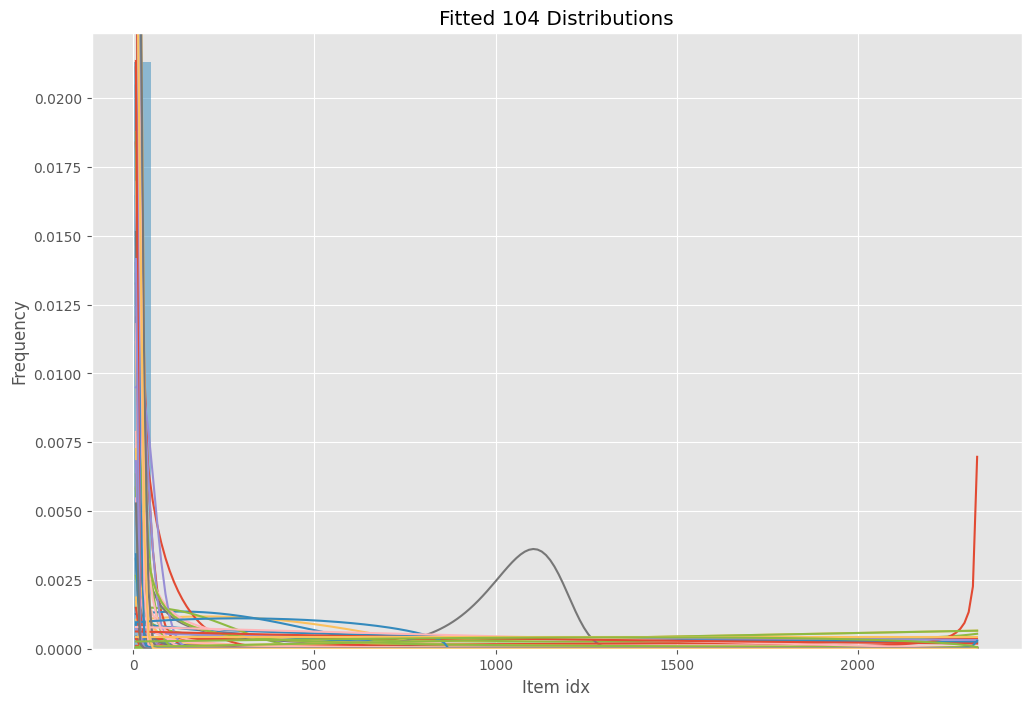

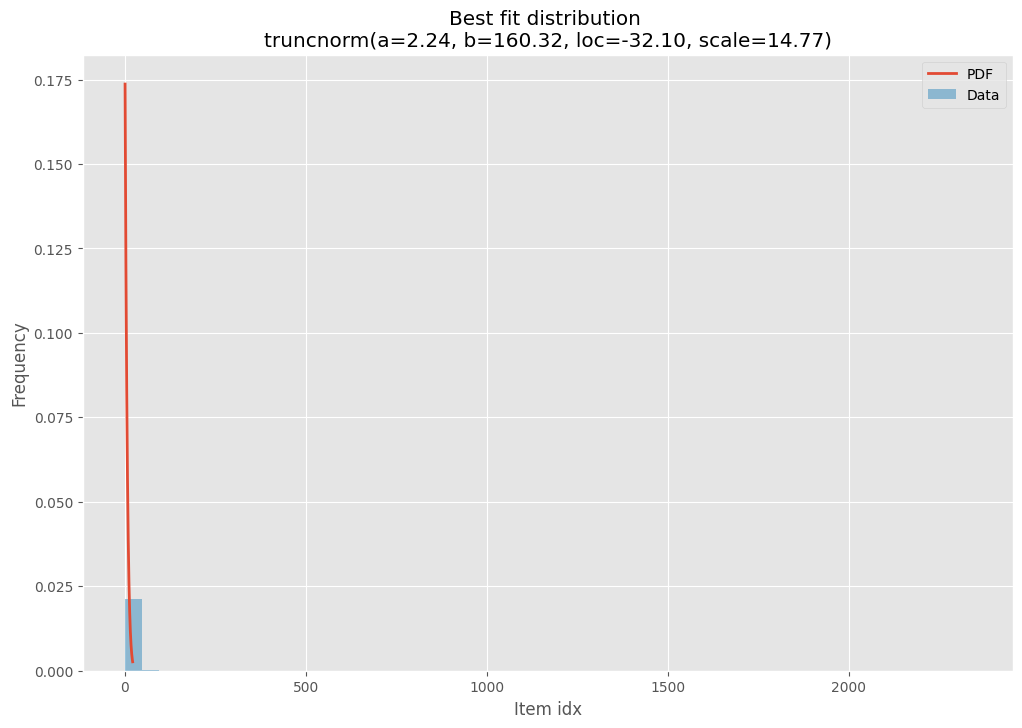

In [22]:
# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(f'Fitted {len(best_distibutions)} Distributions')
ax.set_xlabel(u'Item idx')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Best fit distribution \n' + dist_str)
ax.set_xlabel(u'Item idx')
ax.set_ylabel('Frequency')

In [43]:

for algo, params in [(t[0],t[1]) for t in best_distibutions]:
    if '.expon_gen' in str(algo):
        break
algo, params

(<scipy.stats._continuous_distns.expon_gen at 0x1294dd7c0>,
 (1.0, 2.5798290275015736))

Text(0, 0.5, 'Frequency')

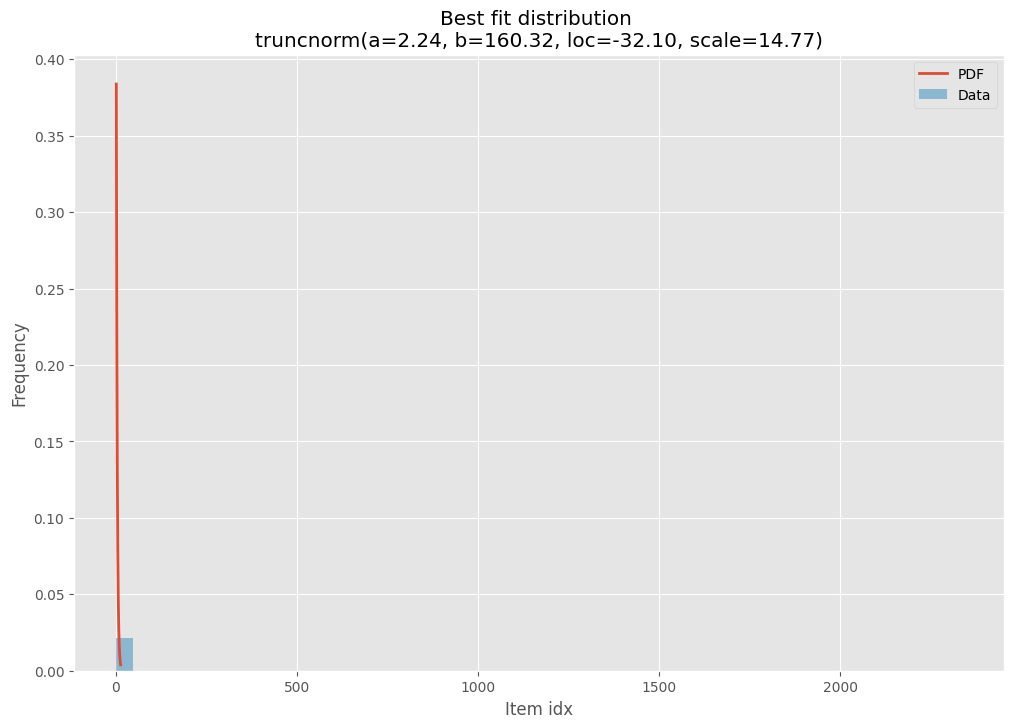

In [46]:

# Make PDF with best params 
pdf = make_pdf(algo, params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Best fit distribution \n' + dist_str)
ax.set_xlabel(u'Item idx')
ax.set_ylabel('Frequency')